# Visualizing parallel event series in Python

## Do movie releases produce literal earthquakes?

We always hear about new movie releases being a "blast", some sure are. But how do two independent events correlate with each other? In this post, I will use Python to visualize two different series of events, plotting them on top of each other to gain insights from time series data.

In [2]:
# Imports
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Paired')
sns.set_style("whitegrid")
%matplotlib inline

# Getting the data

To make this example more fun, I decided to use two independent series of events for which data is readily available in the internet:

- [List of earthquakes around the world](http://world-earthquakes.com/index.php?option=eqs&year=2016)
- [List of film releases in the USA](http://www.firstshowing.net/schedule2016/)

## Clean and prepare earthquake data

We start by downloading the .csv export from the [world earthquake website](http://world-earthquakes.com/index.php?option=eqs&year=2016) to the 'data' directory and reading the file into a pandas DataFrame

In [4]:
df = pd.read_csv('data/earthquakes_raw.csv', sep=';')
df.dropna((0,1), how='all', inplace=True)
df.head()

,Date,Zone/Region,Magnitude (Mw),Year
0,December 09,SOLOMON ISLANDS,6.9,2016
1,December 08,CALIFORNIA,6.5,2016
2,December 08,SOLOMON ISLANDS,7.8,2016
3,December 06,SUMATRA,6.5,2016
4,November 25,CHINA,6.6,2016


We have to unify the date information from the Date and Year columns. Then we can save the cleaned-up earthquake date data to a file 'data/earthquakes.csv'

In [5]:
df['Date'] = df['Date'] + ' ' + df['Year'].map(str)
del df['Year']
df['Date'] = df['Date'].apply(lambda x: 
                              datetime.strptime(x, '%B %d %Y'))
df['Date'].to_csv('data/earthquakes.csv')
df.head()

,Date,Zone/Region,Magnitude (Mw)
0,2016-12-09,SOLOMON ISLANDS,6.9
1,2016-12-08,CALIFORNIA,6.5
2,2016-12-08,SOLOMON ISLANDS,7.8
3,2016-12-06,SUMATRA,6.5
4,2016-11-25,CHINA,6.6


## Clean and prepare movie release data

The movie release data was retrieved from [this website](http://www.firstshowing.net/schedule2016/) and saved to the 'data' directory. We then read the file into a pandas DataFrame. The resulting table tells us the release date and which movies where released on a that date (up to 5 movies).

In [6]:
df = pd.read_csv('data/filmrelease_raw.csv', sep=';', header=None)
df.dropna((0,1), how='all', inplace=True, thresh=2)
df.columns = ['Date', 'Film1', 'Film2', 'Film3', 'Film4', 'Film5']
df.head(), df.tail()

(                        Date              Film1            Film2  \
 0    Friday, January 9, 2015            Taken 3              NaN   
 4   Friday, January 16, 2015           Blackhat       Paddington   
 14  Friday, January 23, 2015          Mortdecai    Strange Magic   
 24  Friday, January 30, 2015     Black or White  Project Almanac   
 34  Friday, February 6, 2015  Jupiter Ascending      Seventh Son   
 
                                    Film3 Film4 Film5  
 0                                    NaN   NaN   NaN  
 4                     The Wedding Ringer   NaN   NaN  
 14                     The Boy Next Door   NaN   NaN  
 24                              The Loft   NaN   NaN  
 34  SpongeBob Movie: Sponge Out of Water   NaN   NaN  ,
                        Date                     Film1         Film2  \
 836      Friday, December 9  🎥 Office Christmas Party           NaN   
 840     Friday, December 16       🎥 Collateral Beauty  🎥 La La Land   
 850  Wednesday, December 21   

Talk about raw _unclean_ data! It seems that, at the top of the table, the date information contains the year (2015). However, upon further inspection we can see that the bottom of the table does not show us the year anymore. From the website information we find out that, after the index 716 and onwards, the missing year information is '2016'. So we add this data to the DataFrame and change the date format to a more readable one.

In [7]:
df.loc[lambda x: x.index >= 716, 'Date'] += ', 2016'
df['Date'] = df['Date'].apply(lambda x: 
                              datetime.strptime(x, '%A, %B %d, %Y'))
df.head()

,Date,Film1,Film2,Film3,Film4,Film5
0,2015-01-09,Taken 3,NaN,NaN,NaN,NaN
4,2015-01-16,Blackhat,Paddington,The Wedding Ringer,NaN,NaN
14,2015-01-23,Mortdecai,Strange Magic,The Boy Next Door,NaN,NaN
24,2015-01-30,Black or White,Project Almanac,The Loft,NaN,NaN
34,2015-02-06,Jupiter Ascending,Seventh Son,SpongeBob Movie: Sponge Out of Water,NaN,NaN


For the purpose of plotting the frequency of an event, we are not interested in what movies were released, but only in how many on a particular date. We can count the movies by replacing the names with ones and calculating the sum.

In [8]:
# replace movie names with ones
df.iloc[:,1:] = df.iloc[:,1:].replace(r'\w', 1.0, regex=True)
df.head()

,Date,Film1,Film2,Film3,Film4,Film5
0,2015-01-09,1.0,NaN,NaN,NaN,NaN
4,2015-01-16,1.0,1.0,1.0,NaN,NaN
14,2015-01-23,1.0,1.0,1.0,NaN,NaN
24,2015-01-30,1.0,1.0,1.0,NaN,NaN
34,2015-02-06,1.0,1.0,1.0,NaN,NaN


We can finally get rid of the unnecessary columns and save the clean data to a file. Now we are ready to start plotting our event series data.

In [9]:
df['film_sum'] =df[['Film1', 'Film2', 'Film3', 'Film4', 'Film5']].sum(axis=1)
df.drop(['Film1', 'Film2', 'Film3', 'Film4', 'Film5'], axis=1, inplace=True)
df.to_csv('data/filmrelease.csv')
df.head()

,Date,film_sum
0,2015-01-09,1.0
4,2015-01-16,3.0
14,2015-01-23,3.0
24,2015-01-30,3.0
34,2015-02-06,3.0


## Load the data to the plotting variables

To use this script, we have to load the clean data that we saved in the previuos steps.

In [10]:
# Load the earthquake data and add a column with ones since there was only one earthquake per row
df1 = pd.read_csv('data/earthquakes.csv', header=None)
del df1[0]
df1.columns = ['Date']
df1['Event1'] = np.ones(len(df1))
df1.head()

,Date,Event1
0,2016-12-09,1.0
1,2016-12-08,1.0
2,2016-12-08,1.0
3,2016-12-06,1.0
4,2016-11-25,1.0


In [11]:
# Load the movie data, the second column already shows us the sum of movie releases
df2 = pd.read_csv('data/filmrelease.csv', header=0)
del df2['Unnamed: 0']
df2.columns = ['Date', 'Event2']
df2.head()

,Date,Event2
0,2015-01-09,1.0
1,2015-01-16,3.0
2,2015-01-23,3.0
3,2015-01-30,3.0
4,2015-02-06,3.0


As end result, we want to have a single DataFrame containing the data for both event series. Moreover, we want to have a continuous time series, including those days in which none of the two events took place (no earthquakes, and no movie releases). We do this by using the concatenate and resample functions of pandas.

In [12]:
# Concatenate both DataFrames into one
df = pd.concat([df1, df2], ignore_index=True)
df = df.set_index(pd.DatetimeIndex(df.Date))
df = df.sort_index()
df = df.resample('1d').sum().fillna(0) # to complete every day
df.head(10)

,Event1,Event2
Date,,
2015-01-09,0.0,1.0
2015-01-10,0.0,0.0
2015-01-11,0.0,0.0
2015-01-12,0.0,0.0
2015-01-13,0.0,0.0
2015-01-14,0.0,0.0
2015-01-15,0.0,0.0
2015-01-16,0.0,3.0
2015-01-17,0.0,0.0


# Calculating and plotting a moving average

We could simply plot each event occurrence as a data point in a time series. However, this will likely yield a graph that is not very informative. Much easier to grasp is a moving average that tells us the average frequency of the events for a defined period of time in the past. We can create columns for these moving averages, which we can then easily plot.

In [13]:
# Calculate moving average
for i in [7*4, 7*4*2]:
    mvav = i # moving average period, i.e. number of points to average
    dfi = np.convolve(df['Event1'], 
                      np.ones((mvav,))*7/mvav # factor for obtaining average
                      , mode='full')
    df['Event1 Moving average %sw' % (int(i/7))] = dfi[:-(i-1)]
    dfj = np.convolve(df['Event2'], 
                      np.ones((mvav,))*7/mvav # factor for obtaining average
                      , mode='full')
    df['Event2 Moving average %sw' % (int(i/7))] = dfj[:-(i-1)]
df.head()

,Event1,Event2,Event1 Moving average 4w,Event2 Moving average 4w,Event1 Moving average 8w,Event2 Moving average 8w
Date,,,,,,
2015-01-09,0.0,1.0,0.0,0.25,0.0,0.125
2015-01-10,0.0,0.0,0.0,0.25,0.0,0.125
2015-01-11,0.0,0.0,0.0,0.25,0.0,0.125
2015-01-12,0.0,0.0,0.0,0.25,0.0,0.125
2015-01-13,0.0,0.0,0.0,0.25,0.0,0.125


The shorter the period that we choose for the moving average, the noisier our graphic will get. Let's settle with a moving average that reflects the frequency during the past 8 weeks. And _voilà_! Now we can see how the frequency of earthquakes and movie releases changed over time.

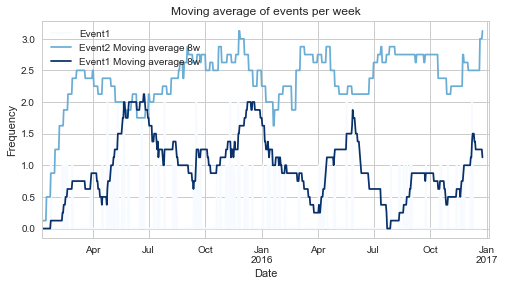

In [14]:
# Plot relevant columns from dataframe
df.loc[:,['Event1', 'Event2 Moving average 8w', 'Event1 Moving average 8w']].\
plot(cmap='Blues', figsize=(8,4))# possible
plt.xlim(df.index[0], df.index.max()+10)
plt.title('Moving average of events per week')
plt.ylabel('Frequency')
plt.show()

# Descriptive analysis of the event occurrence 

What other insights can we get from this data set? Two very dissimilar series of events, one natural, and one man-made, will surely have very different properties. Let's start with a simple question: on which days of the week do both events typically happen?

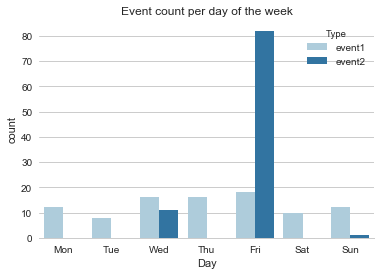

In [15]:
#%% DAY OF THE WEEK ANALYSIS

# create column for day of the week
df['Day'] = df.index.dayofweek
df['Day'] = df.Day.astype('category')
df.Day.cat.categories = ['Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# create column for type
df['Type'] = np.where(df['Event1']>0, 'event1', np.where(df['Event2']>0,\
 'event2', np.nan))
df['Type'] = df['Type'].astype('category')
df['Type'] = df['Type'].cat.remove_categories(['nan'])

# show count for each day
#df[(df.Event1 == 1)&(df.Day == 'Mon')].Day.count()

# plot count data per day of the week
plt.figure()
plt.title('Event count per day of the week')
sns.countplot(data=df, x='Day', hue='Type')
sns.despine(left=True)
plt.show()

We can see that nature does not respect our weekends, as earthquakes seem to be flatly distributed by day of the week.

The movie releases, on the other hand, are most frequent on Friday, followed by Wednesday and a few on Sunday (it's almost as if movie release days were _chosen_ by someone... /s). It seems that, if you're planning to release a new movie in the US, Friday is the way to go. People are usually happy to start the weekend with a leisurely activity, so that makes sense. As of why Saturdays and Sundays are almost not used as movie release days, even though on this days people are also usually free from work, it would be interesting to find out why. Another intriguing finding is the not high but remarkable number of releases on Wednesdays. Don't people work on Thursdays?

## Analysis of frequency per week

The world is a big place (or is it a small world?) and earthquakes occur all the time, even though we might not always find out. On the other hand, I would expect that movie releases occur much more frequently. So let's take a look at the data by plotting histograms for both events side by side.

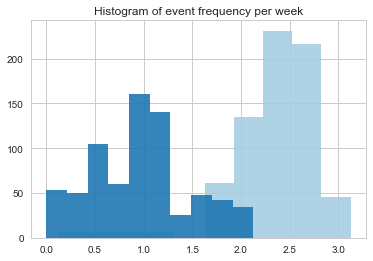

(<matplotlib.axes._subplots.AxesSubplot at 0x11ee50940>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ee50940>)

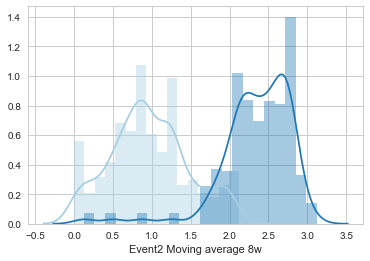

In [16]:
# joint histograms
plt.figure()
df['Event2 Moving average 8w'].hist(alpha=.9)
df['Event1 Moving average 8w'].hist(alpha=.9)
plt.title('Histogram of event frequency per week')
plt.show()

# With seaborn
sns.distplot(df['Event1 Moving average 8w']), \
sns.distplot(df['Event2 Moving average 8w'])

Luckily, movie releases are much more frequent per week as earthquakes. On most weeks, there are between two and three movie releases, compared to 0.5 to 1.5 earthquakes.

# Final remarks

In this post, we gathered information on the occurrence of two events: earthquakes around the world, and movie releases in the US. By plotting their moving averages we could better compare when they occurred and gained some interesting insights about how they compare. All thanks to Python!